In [1]:
import theano
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-21 13:42:35.595854
numcores: 28


In [2]:
m = [1,2,3];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data1=pm.MvNormal.dist(mu=m,cov=cov).random(size=2000)

m = [7,8,9];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data2=pm.MvNormal.dist(mu=m,cov=cov).random(size=1000)

#m = [15,16,17];sd=[1,1,1];cov=np.eye(len(sd))*sd;
#data3=pm.MvNormal.dist(mu=m,cov=cov).random(size=100)

data=np.vstack((data1,data2))

nsamples=data.shape[0]
ndim=data.shape[1]

print('Multivariate Data, 2 clusters, 123 ; 789,100 each')

Multivariate Data, 2 clusters, 123 ; 789,100 each


In [3]:
# Working model, inferring mus 

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    #beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(pm.Beta.dist(alpha=1,beta=alpha,shape=infinity).random()))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    mus=[pm.Uniform('mu{}'.format(i),0,10,shape=ndim) for i in range(infinity)]
    components = [pm.MvNormal.dist(mu=mus[i], cov=np.eye(ndim), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [4]:
trace = pm.sample(draws=10,tune=5,cores=3,init='auto',n_init=5,model=model)
print(pm.summary(trace));

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu4, mu3, mu2, mu1, mu0, alpha]
Sampling 3 chains, 0 divergences: 100%|██████████| 45/45 [00:08<00:00,  5.14draws/s]
/data/aglinsai/.conda/envs/py3/lib/python3.7/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha   1.285  1.405   0.165    3.357      0.275    0.197      26.0    26.0   
w[0]    0.894  0.000   0.894    0.894      0.000    0.000      30.0    30.0   
w[1]    0.096  0.000   0.096    0.096      0.000    0.000      30.0    30.0   
w[2]    0.010  0.000   0.010    0.010      0.000    0.000      30.0    30.0   
w[3]    0.000  0.000   0.000    0.000      0.000    0.000      30.0    30.0   
w[4]    0.000  0.000   0.000    0.000      0.000    0.000      30.0    30.0   
mu0[0]  6.980  0.231   6.872    7.103      0.049    0.036      22.0    22.0   
mu0[1]  7.736  0.632   5.820    8.086      0.182    0.134      12.0    12.0   
mu0[2]  8.557  0.974   5.395    9.238      0.295    0.220      11.0    10.0   
mu1[0]  2.109  2.110   0.421    6.398      0.751    0.558       8.0     8.0   
mu1[1]  2.793  1.360   1.956    5.464      0.477    0.353       8.0     8.0   
mu1[2]  3.002  0.185   2.728    3.548      0.055    

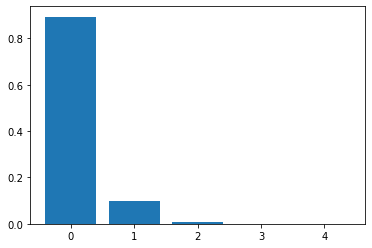

In [5]:
plt.bar(np.arange(infinity),trace['w'].mean(axis=0));

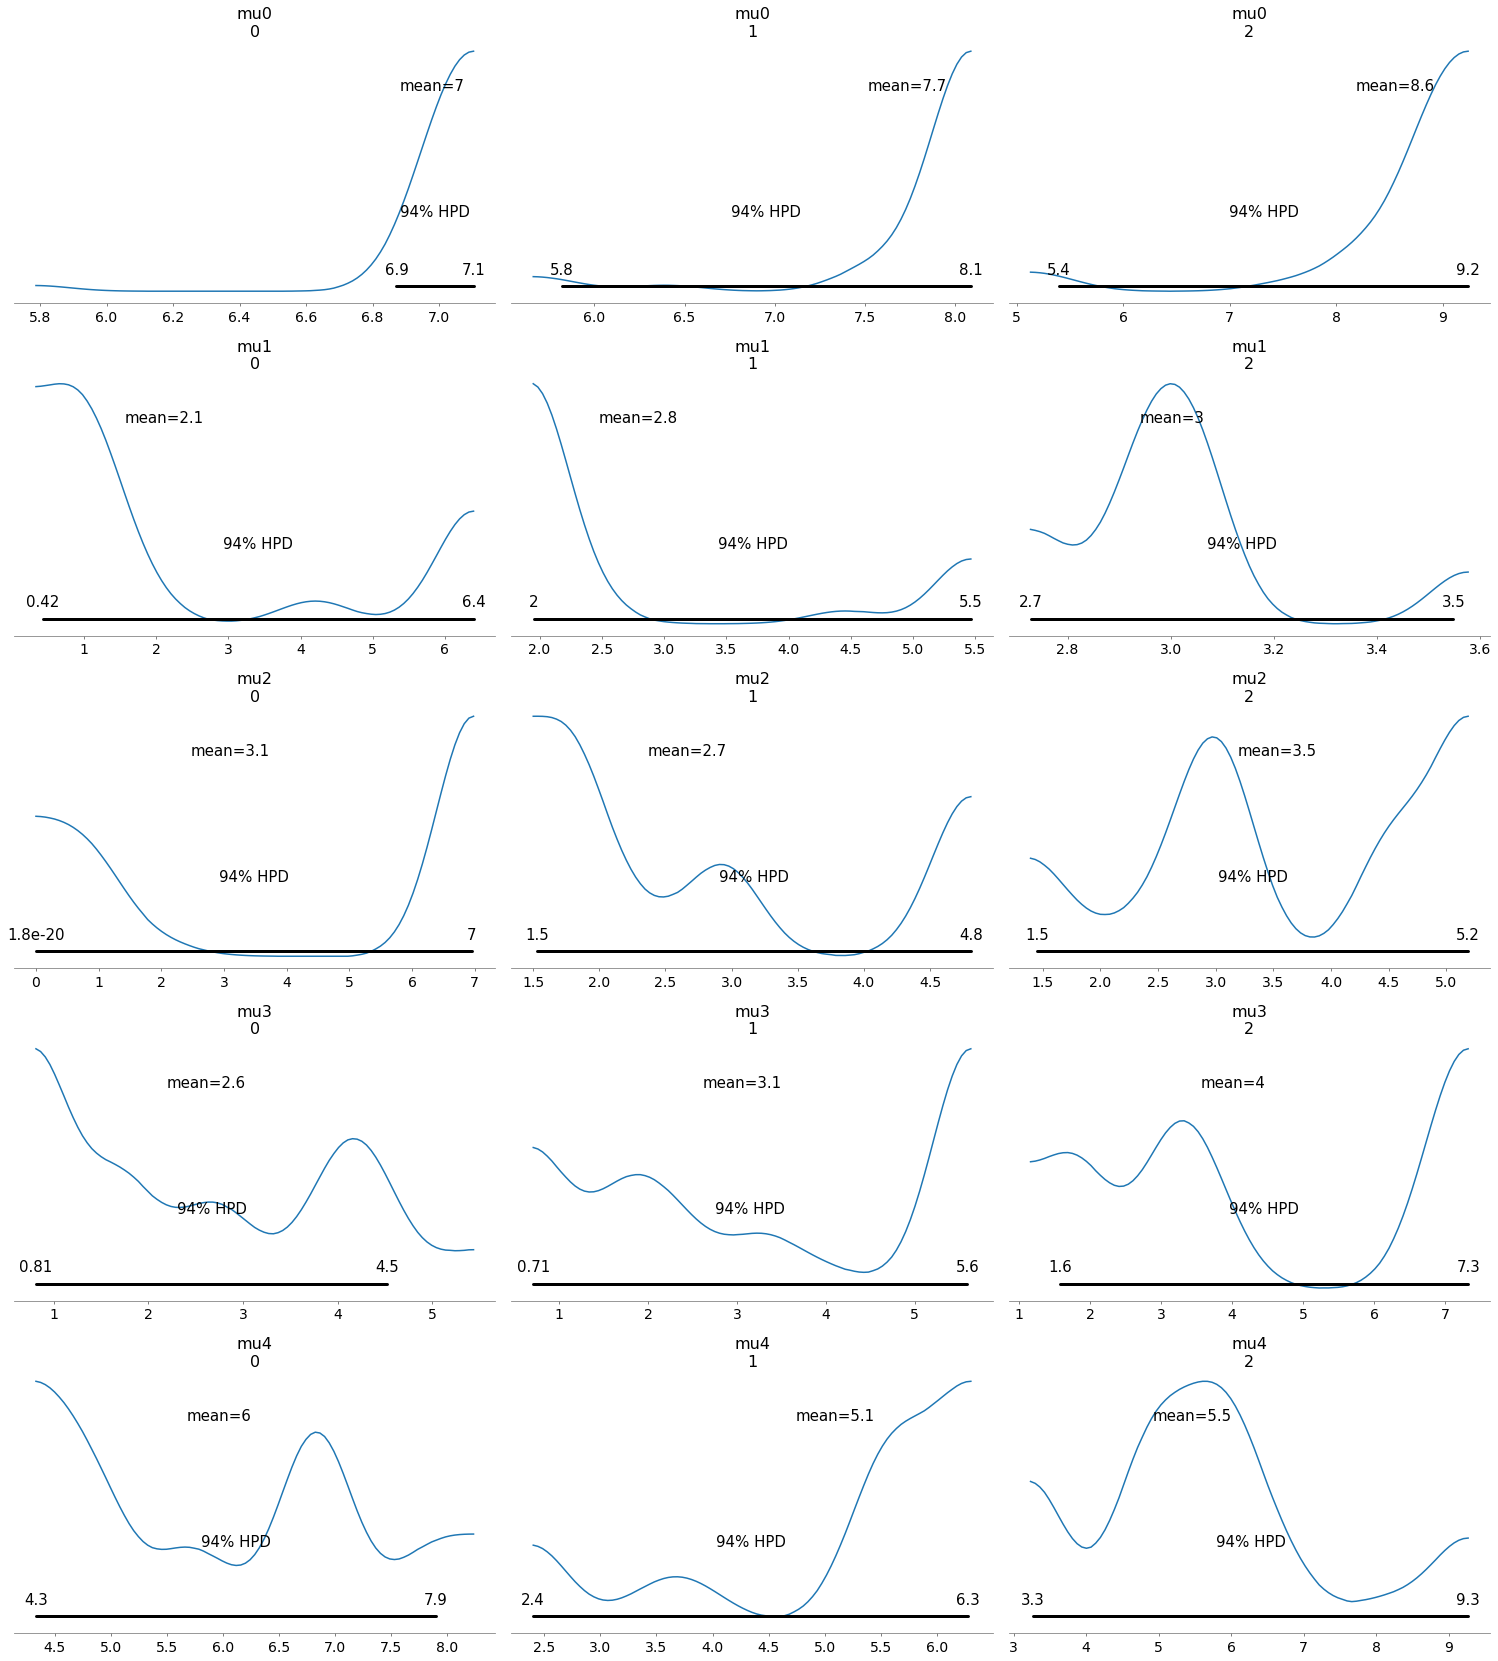

In [6]:
pm.plot_posterior(data=trace,var_names=['mu0','mu1','mu2','mu3','mu4']);
#pm.plot_posterior(data=trace,var_names=['mu1'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu2'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu3'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu4'],backend="matplotlib");

In [7]:
t_finish=now()

In [8]:
print('Time it took to run {}'.format(str(t_finish-t_start)))

Time it took to run 0:00:33.587123


In [9]:
#with model:
#    trace = pm.sample(draws=5000,cores=8,tune=500)    

In [10]:
#with model:
#    trace = pm.find_MAP()